In [1]:
!pip install xee

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 19.7 MB/s eta 0:00:00


In [11]:
import xee
import ee
import geemap
import xarray as xr
import matplotlib.pyplot as plt


In [3]:
ee.Authenticate()
ee.Initialize(project='ee-aviresearch',opt_url='https://earthengine-highvolume.googleapis.com')

In [4]:
col = ee.ImageCollection("NASA/GSFC/MERRA/aer/2").select('DUEXTT25')

In [5]:
time_start = ee.Date('2008')
time_end = ee.Date('2009')

time_dif = time_end.difference(time_start,'days')
time_list = ee.List.sequence(0,ee.Number(time_dif).subtract(1)).map(lambda interval: time_start.advance(interval,'days'))

In [6]:
def daily_agg(date):
  start_date = ee.Date(date)
  end_date = start_date.advance(1,'days')

  image = col.filterDate(start_date,end_date).mean()

  return image.set('system:time_start',start_date.millis())

In [7]:
dailly_col = ee.ImageCollection(time_list.map(daily_agg))

In [8]:
loc =[79.95185288464742,6.334094825995107,81.29218491589742,8.197586507915597]

In [9]:
ds = xr.open_dataset(dailly_col,engine='ee',crs='EPSG:4326',scale=0.5,geometry=loc)

In [10]:
ds

<xarray.Dataset> Size: 21kB
Dimensions:   (time: 366, lon: 3, lat: 4)
Coordinates:
  * time      (time) datetime64[ns] 3kB 2008-01-01 2008-01-02 ... 2008-12-31
  * lon       (lon) float64 24B 80.2 80.7 81.2
  * lat       (lat) float64 32B 6.584 7.084 7.584 8.084
Data variables:
    DUEXTT25  (time, lon, lat) float32 18kB ...
Attributes:
    crs:      EPSG:4326

In [12]:
ds_mean = ds.mean('time')

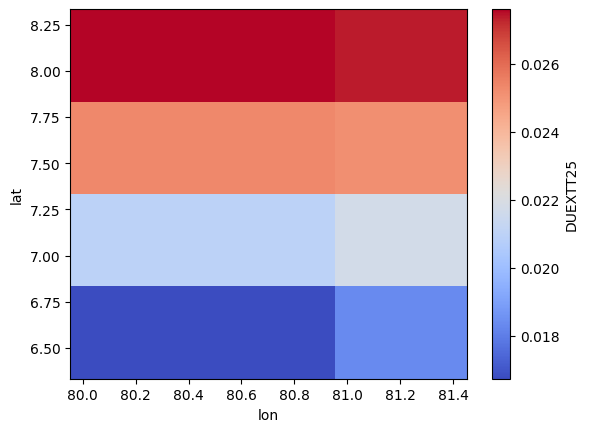

In [13]:
ds_mean.DUEXTT25.plot(x='lon',y='lat',cmap='coolwarm',robust=True)

In [14]:
ds_mean.DUEXTT25.to_dataframe().describe()

,DUEXTT25
count,12.000000
mean,0.022823
std,0.004121
min,0.016737
25%,0.020312
50%,0.023446
75%,0.025840
max,0.027604


In [15]:
monthly = ds.resample(time='M').mean('time')

/usr/local/lib/python3.11/dist-packages/xarray/groupers.py:509: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  self.index_grouper = pd.Grouper(


In [16]:
monthly

<xarray.Dataset> Size: 728B
Dimensions:   (time: 12, lon: 3, lat: 4)
Coordinates:
  * lon       (lon) float64 24B 80.2 80.7 81.2
  * lat       (lat) float64 32B 6.584 7.084 7.584 8.084
  * time      (time) datetime64[ns] 96B 2008-01-31 2008-02-29 ... 2008-12-31
Data variables:
    DUEXTT25  (time, lon, lat) float32 576B 0.003497 0.004288 ... 0.002248
Attributes:
    crs:      EPSG:4326

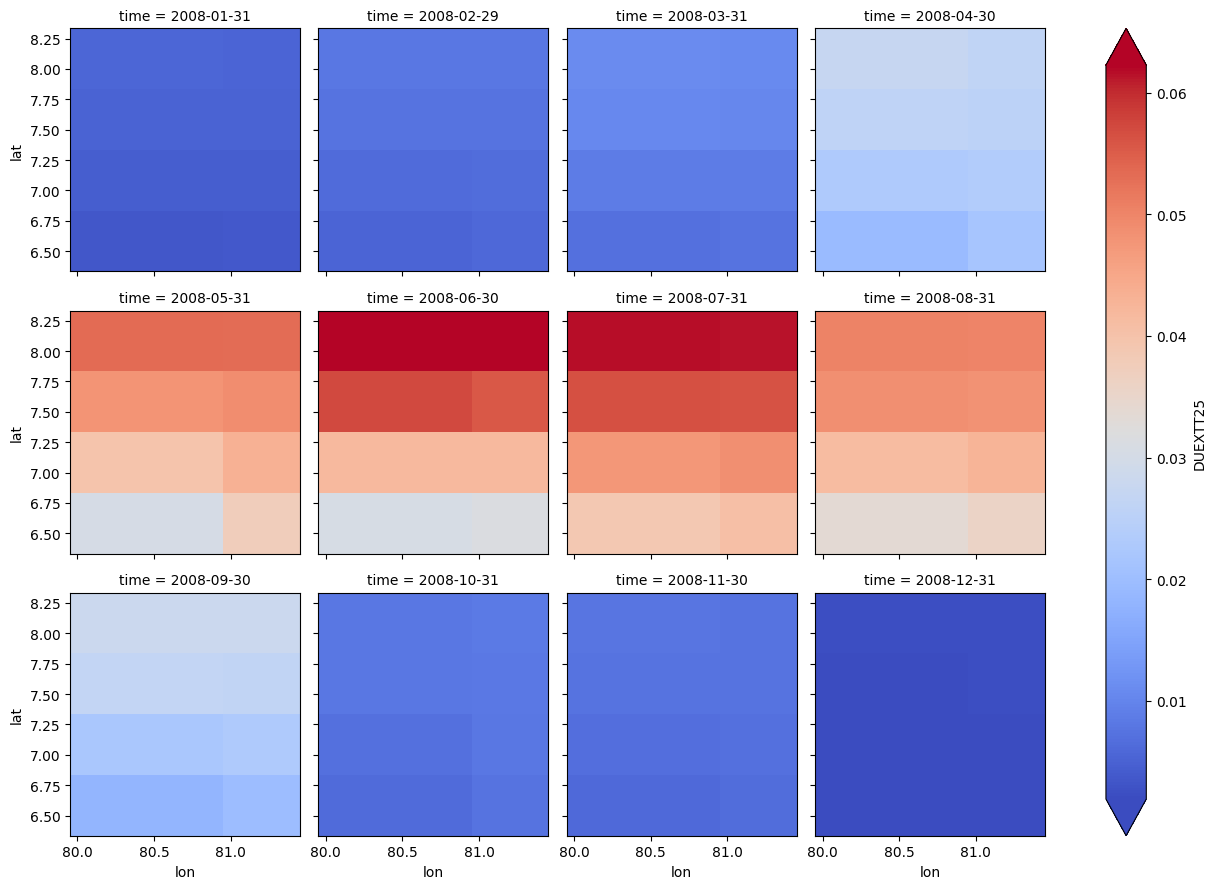

In [17]:
monthly.DUEXTT25.plot(x='lon',y='lat',col='time',col_wrap=4,cmap='coolwarm',robust=True)